In [3]:
# !pip install -U "jax[tpu]" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
# !pip install vartests
!pip install numpyro
# # !pip install flax
# # !pip install aeppl==0.0.17
# !pip install blackjax
# # !pip install jax==0.4.26

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 4.9 MB/s eta 0:00:00


## Stochastic Volatility model

In [4]:
%matplotlib inline

import numpy as np
import scipy as sp
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns


import pymc as pm
import arviz as az

import os
import graphviz

# import jax
# import blackjax
import pymc.sampling_jax
# from jax.lib import xla_bridge

import pytensor
from pymc.pytensorf import collect_default_updates

import cv2
import numpy as np
from google.colab import files

print(f'numpy version: {np.__version__}')
print(f'scipy version: {sp.__version__}')
print(f'arviz version: {az.__version__}')
print(f'pymc version: {pm.__version__}')
# print(f'blackjax version: {blackjax.__version__}')
# print(f'jax version: {jax.__version__}')
# print(f'platform: {xla_bridge.get_backend().platform}')
# print(f'device: {jax.devices()}')

numpy version: 1.25.2
scipy version: 1.11.4
arviz version: 0.15.1
pymc version: 5.10.4


### Upload and scale data

In [5]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/My Drive/course_3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/course_3


In [6]:
encoding_name = 'cp1251'
hour_ahead_df1 = pd.read_csv('oes_hour_01012023_01062023.csv', sep=';', encoding=encoding_name)
hour_ahead_df2 = pd.read_csv('oes_hour_02062023_01022024.csv', sep=';', encoding=encoding_name)
rsv_hour_df = pd.concat([hour_ahead_df2, hour_ahead_df1], ignore_index=True)

res_name = 'Индекс равновесных цен на покупку электроэнергии, руб./МВт*ч'
rsv_hour_df.rename(columns={'Дата':'Date','Час':'Hour', res_name:'Price, RUB/MWh.'}, inplace=True)
rsv_hour_df.drop(columns=['Unnamed: 9'], inplace=True)
rsv_hour_df['log_Price, RUB/MWh.'] = np.log(rsv_hour_df['Price, RUB/MWh.'])
rsv_hour_df['Diff'] = -rsv_hour_df['log_Price, RUB/MWh.'].diff(periods=-1)
rsv_hour_df.fillna(0, inplace=True)
rsv_hour_df['Datetime'] = pd.to_datetime(rsv_hour_df['Date'], format="%d.%m.%Y")
rsv_hour_df.sort_values(by=['Datetime', 'Hour'], ignore_index=True, inplace=True)
rsv_hour_df.drop(columns=['ОЭС', 'Объем полного планового потребления, МВт*ч', 'Объем планового производства, МВт*ч',
                          'Индекс равновесных цен на продажу электроэнергии, руб.МВт*ч', 'Максимальный индекс равновесной цены, руб.МВт*ч',
                          'Минимальный индекс равновесной цены, руб.МВт*ч', 'Datetime', 'Date', 'Hour'], inplace=True)

hour_temp_df = pd.read_csv('Moscow,Russia 2023-01-01 to 2024-02-01.csv')
# hour_temp_df.drop(index=0, inplace=True)
hour_temp_df.reset_index(inplace=True)
hour_temp_df.rename(columns={'datetime':'Datetime','temp':'Temp'}, inplace=True)
hour_temp_df['Temp'] = hour_temp_df['Temp'].replace(0, 1)
hour_temp_df['log_Temp'] = np.log(np.abs(hour_temp_df['Temp']))
# hour_temp_df['Diff_temp'] = hour_temp_df['Temp'].diff()
hour_temp_df['Datetime'] = hour_temp_df['Datetime'].astype('datetime64[ns]')
hour_temp_df = hour_temp_df[['Datetime', 'Temp', 'log_Temp']]

df = pd.concat([hour_temp_df, rsv_hour_df], axis=1)

# Плановые отключения электроэнергии в начале августа 2023 года, в эти дни невозможны адекватные прогназирования.
index = df[df['Diff'] > df['Diff'].quantile(.9999)].index
df.drop(index, inplace=True)

df.loc[:, 'Weekday'] = df['Datetime'].dt.day_name()
one_hot = pd.get_dummies(df['Weekday'], dtype='int')
df = pd.concat([df, one_hot[['Saturday', 'Sunday', 'Monday']]], axis=1)
df.drop(columns=['Weekday'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(f'Данные цены электроэнергии с 01.01.2023 по 01.06.2023: {hour_ahead_df1.shape}')
print(f'Данные цены электроэнергии с 02.06.2023 по 01.02.2024: {hour_ahead_df2.shape}')
print(f'Данные цены электроэнергии с 01.01.2023 по 01.02.2024: {rsv_hour_df.shape}')
print(f'Исторический климат г. Москвы 01.01.2023 по 01.02.2024: {hour_temp_df.shape}')
df.head()

Данные цены электроэнергии с 01.01.2023 по 01.06.2023: (3648, 10)
Данные цены электроэнергии с 02.06.2023 по 01.02.2024: (5880, 10)
Данные цены электроэнергии с 01.01.2023 по 01.02.2024: (9528, 3)
Исторический климат г. Москвы 01.01.2023 по 01.02.2024: (9528, 3)


,Datetime,Temp,log_Temp,"Price, RUB/MWh.","log_Price, RUB/MWh.",Diff,Saturday,Sunday,Monday
0,2023-01-01 00:00:00,0.4,-0.916291,1179.55,7.072888,-0.048506,0,1,0
1,2023-01-01 01:00:00,0.4,-0.916291,1123.70,7.024382,0.035390,0,1,0
2,2023-01-01 02:00:00,1.0,0.000000,1164.18,7.059772,-0.043970,0,1,0
3,2023-01-01 03:00:00,1.0,0.000000,1114.10,7.015802,-0.020393,0,1,0
4,2023-01-01 04:00:00,1.0,0.000000,1091.61,6.995409,0.000458,0,1,0


In [ ]:
# encoding_name = 'cp1251'
# rsv_hour_df = pd.read_csv('oes_date_15052021_01012024.csv', sep=';', encoding=encoding_name)

# res_name = 'Индекс равновесных цен на покупку электроэнергии, руб./МВт*ч'
# rsv_hour_df.rename(columns={'Дата':'Date','Час':'Hour', res_name:'Price, RUB/MWh.'}, inplace=True)
# rsv_hour_df.drop(columns=['Unnamed: 8'], inplace=True)
# rsv_hour_df['Datetime'] = pd.to_datetime(rsv_hour_df['Date'], format="%d.%m.%Y")
# rsv_hour_df.sort_values(by=['Datetime'], ignore_index=True, inplace=True)
# rsv_hour_df['Diff'] = -np.log(rsv_hour_df['Price, RUB/MWh.']).diff(periods=-1)
# rsv_hour_df.fillna(0, inplace=True)
# rsv_hour_df.drop(columns=['ОЭС', 'Объем полного планового потребления, МВт*ч', 'Объем планового производства, МВт*ч',
#                           'Индекс равновесных цен на продажу электроэнергии, руб.МВт*ч', 'Максимальный индекс равновесной цены, руб.МВт*ч',
#                           'Минимальный индекс равновесной цены, руб.МВт*ч', 'Datetime', 'Date'], inplace=True)

# hour_temp_df = pd.read_csv('Moscow,Russia 2020-01-01 to 2024-01-01.csv')
# # hour_temp_df.drop(index=0, inplace=True)
# hour_temp_df.reset_index(inplace=True)
# hour_temp_df.rename(columns={'datetime':'Datetime','temp':'Temp'}, inplace=True)

# hour_temp_df['Temp'] = hour_temp_df['Temp'].replace(0, 1)
# hour_temp_df['log_Temp'] = np.log(np.abs(hour_temp_df['Temp']))
# hour_temp_df['Datetime'] = hour_temp_df['Datetime'].astype('datetime64[ns]')
# hour_temp_df = hour_temp_df[['Datetime', 'Temp', 'log_Temp']]

# df = pd.concat([hour_temp_df.loc[500:].reset_index(), rsv_hour_df], axis=1)

# # Плановые отключения электроэнергии в начале августа 2023 года, в эти дни невозможны адекватные прогназирования.
# index = df[df['Diff'] > df['Diff'].quantile(.9999)].index
# df.drop(index, inplace=True)

# df.loc[:, 'Weekday'] = df['Datetime'].dt.day_name()
# one_hot = pd.get_dummies(df['Weekday'], dtype='int')
# df = pd.concat([df, one_hot[['Saturday', 'Sunday', 'Monday']]], axis=1)
# df.drop(columns=['Weekday'], inplace=True)
# df.reset_index(drop=True, inplace=True)
# df = df.fillna(0)

# # print(f'Данные цены электроэнергии с 01.01.2023 по 01.06.2023: {hour_ahead_df1.shape}')
# # print(f'Данные цены электроэнергии с 02.06.2023 по 01.02.2024: {hour_ahead_df2.shape}')
# print(f'Данные цены электроэнергии с 01.01.2023 по 01.02.2024: {rsv_hour_df.shape}')
# print(f'Исторический климат г. Москвы 01.01.2023 по 01.02.2024: {hour_temp_df.shape}')
# df.head()

In [ ]:
df[df['Temp'] == 0]

,Datetime,Temp,log_Temp,"Price, RUB/MWh.","log_Price, RUB/MWh.",Diff,Saturday,Sunday,Monday


[Text(0.5, 1.0, 'Температура')]

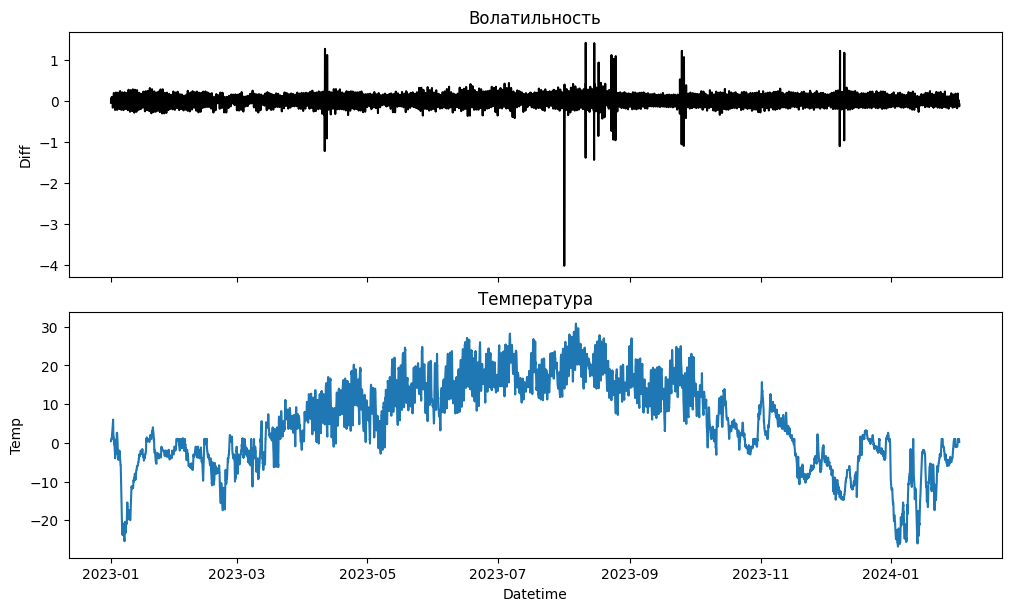

In [7]:
mask = "Волатильность и температура"

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout='constrained'
)
sns.lineplot(x='Datetime', y='Diff', data=df, color='black', ax=ax[0])
sns.lineplot(x='Datetime', y='Temp', data=df, color='C0', ax=ax[1])
ax[0].set(title='Волатильность')
ax[1].set(title='Температура')

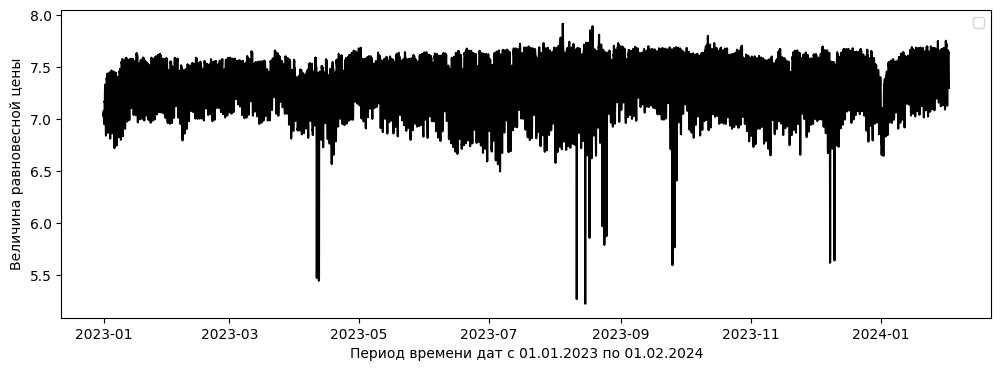

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df['Datetime'], np.log(df['Price, RUB/MWh.']), color='black')
x_label = 'Период времени дат с 01.01.2023 по 01.02.2024'
y_label = 'Величина равновесной цены'
ax.set(xlabel=x_label, ylabel=y_label)
ax.legend();

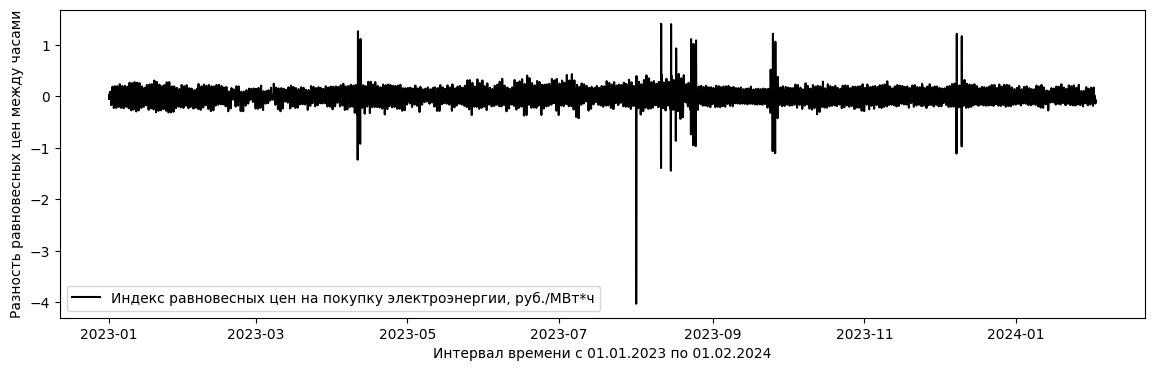

In [9]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df['Datetime'], df['Diff'], label=res_name, color='black')
x_label = 'Интервал времени с 01.01.2023 по 01.02.2024'
y_label = 'Разность равновесных цен между часами'
ax.set(xlabel=x_label, ylabel=y_label)
ax.legend();

### Building Model



In [15]:
df = df[:100]
T = len(df)

import pytensor.tensor as pt


def one_step(t, y_tm1, h_tm1,
              q, xi_D, xi_U, X, d_Sat, d_Sun, d_Mon, eps_1, eps_2,
              kappa_h, theta_h, sigma_h, rho,
              mu, psi, d_sat, d_sun, d_mon):

    j_t = pt.switch(pt.eq(q[t], 0), -xi_D[t], pt.switch(pt.eq(q[t], 2), xi_U[t], 0))
    y_t = y_tm1 + mu + psi * X[t] + d_sat * d_Sat[t] + d_sun * d_Sun[t] + d_mon * d_Mon[t] + pt.sqrt(pt.exp(h_tm1)) * eps_1[t] + j_t
    h_t = h_tm1 + kappa_h * (theta_h - h_tm1) + sigma_h * (rho * eps_1[t] + pt.sqrt(1 - rho**2) * eps_2[t])

    return j_t, y_t, h_t

def make_svdejx_model(df):
    coords={'Datetime':df['Datetime'].values}

    with pm.Model(coords=coords) as model:

        # Априорные распределения Параметры
        mu = pm.Normal('mu', mu=0., sigma=10.)
        kappa_h = pm.TruncatedNormal('kappa_h', mu=1., sigma=6, lower=0., upper=2.)
        theta_h = pm.Normal('theta_h', mu=0., sigma=10.)
        omega_h = pm.InverseGamma('omega_h', alpha=3., beta=1/20)
        phi_h = pm.Normal('phi_h', mu=0., sigma=0.5 * omega_h)

        eta_D = pm.InverseGamma('eta_D', alpha=1.86, beta=0.43)
        eta_U = pm.InverseGamma('eta_U', alpha=1.86, beta=0.43)

        # p_D, p_0, p_U = pm.Dirichlet('p', a=np.ones(3))

        psi = pm.Normal('psi', mu=0., sigma=10.)

        d_sat = pm.Normal('d_sat', mu=0., sigma=10.)
        d_sun = pm.Normal('d_sun', mu=0., sigma=10.)
        d_mon = pm.Normal('d_mon', mu=0., sigma=10.)

        eps_1 = pm.Normal('eps_1', mu=0., sigma=1., dims='Datetime')
        eps_2 = pm.Normal('eps_2', mu=0., sigma=1., dims='Datetime')

        # Скрытые переменные
        p = np.random.dirichlet(np.ones(3), size=T)
        q = pm.MutableData('q', np.apply_along_axis(lambda x: np.random.choice(3, p=x), axis=1, arr=p), dims='Datetime')

        # q = pm.Categorical('q', p=p, dims='Datetime')
        xi_D = pm.Exponential('xi_D', lam=eta_D, dims='Datetime')
        xi_U = pm.Exponential('xi_U', lam=eta_U, dims='Datetime')

        y_init = df['log_Price, RUB/MWh.'][0]
        # y_init = df['Price, RUB/MWh.'][0]
        h_init = df['Diff'][0]
        # h_init = pm.Normal('h_init', mu=0., sigma=1.)

        d_Sat = pm.MutableData('d_Sat', df['Saturday'], dims='Datetime')
        d_Sun = pm.MutableData('d_Sun', df['Sunday'], dims='Datetime')
        d_Mon = pm.MutableData('d_Mon', df['Monday'], dims='Datetime')
        X = pm.MutableData('X', df['log_Temp'], dims='Datetime')

        # rho = pm.Normal('d_mon1', mu=0., sigma=1.)
        # sigma_h = pm.Normal('d_m2on', mu=0., sigma=1.)

        # rho = pm.Uniform('rho', lower=-1., upper=1., dims='Datetime')
        rho = omega_h
        sigma_h = phi_h
        # rho = (-phi_h / pt.sqrt(phi_h**2 + omega_h))
        # sigma_h = phi_h / rho

        (j_dist, y_dist, h_dist), _ = pytensor.scan(fn=one_step,
                                            sequences=[pt.arange(1, T)],
                                            outputs_info=[None, y_init, h_init],
                                            non_sequences=[q, xi_D, xi_U, X, d_Sat, d_Sun, d_Mon, eps_1, eps_2,
                                                            kappa_h, theta_h, sigma_h, rho,
                                                            mu, psi, d_sat, d_sun, d_mon],
                                            n_steps=T - 1,
                                            name='one_step',
                                            strict=True)

        j = pm.Deterministic('j', pt.concatenate([[0], j_dist]), dims='Datetime')
        h = pm.Deterministic('h', pt.concatenate([h_init[None], h_dist]), dims='Datetime')
        y_exp = pm.Deterministic('y_exp', pt.concatenate([y_init[None], y_dist]), dims='Datetime')

        y_obs = pm.Normal('y_obs', mu=y_exp, sigma=1, observed=df['log_Price, RUB/MWh.'], dims='Datetime')

        return model

svdejx_model = make_svdejx_model(df)

### Check the model

In [ ]:
# dot = pm.model_to_graphviz(svdejx_model )
# dot.render('graph_SVDEJX.gv', format='png', view=False)
# files.download('graph_SVDEJX.gv.png')
# dot

In [ ]:
# prices = df['Price, RUB/MWh.'].values

# price_innov = np.diff(prices)
# volatility = np.abs(price_innov)
# vol_innov = np.diff(volatility)

#    np.corrcoef(price_innov[:-1], vol_innov)[0, 1]
# leverage_corr

In [ ]:
rng = np.random.RandomState(1234)
with svdejx_model:
    trace = pm.sample_prior_predictive(samples=500, random_seed=rng)

prior_predictive = az.extract(trace, group='prior')

In [ ]:
prior_predictive

<xarray.Dataset>
Dimensions:   (sample: 500, Datetime: 9527)
Coordinates:
  * Datetime  (Datetime) datetime64[ns] 2023-01-01 ... 2024-02-01T23:00:00
  * sample    (sample) object MultiIndex
  * chain     (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * draw      (sample) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables: (12/18)
    kappa_h   (sample) float64 0.207 1.155 1.172 0.8644 ... 1.194 0.5365 0.7891
    d_sat     (sample) float64 7.971 -16.78 0.8501 ... -6.822 13.77 -2.434
    y_exp     (Datetime, sample) float64 7.073 7.073 ... -2.273e+05 -1.361e+04
    psi       (sample) float64 7.797 -0.7037 9.407 -11.42 ... 6.185 -11.72 7.399
    d_mon     (sample) float64 13.88 -3.072 15.95 8.919 ... -17.16 2.547 -4.47
    theta_h   (sample) float64 2.753 13.93 21.58 -18.21 ... 11.17 -22.12 -8.351
    ...        ...
    eta_D     (sample) float64 0.3091 1.351 0.819 2.301 ... 0.1587 0.2476 0.1044
    mu        (sample) float64 -8.928 -12.55 2.899 ... -16.01 -3.378 -14.15
    j         (Datetime, sample) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    eta_U     (sample) float64 0.3236 0.4234 0.5355 ... 0.3774 0.2529 0.2021
    eps_1     (Datetime, sample) float64 0.1151 0.3722 0.7945 ... -0.7058 1.671
    omega_h   (sample) float64 0.0148 0.04516 0.03807 ... 0.04624 0.0212 0.02092
Attributes:
    created_at:                 2024-05-21T07:52:47.244291
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4

In [ ]:
# fig, ax = plt.subplots(figsize=(14, 4))
# ax.plot(df['Datetime'], np.log(df['Price, RUB/MWh.']), lw=1, color='black', label='Реальная цена равновесных цен электроэнергии в логарифме')
# ax.plot(
#     prior_predictive['Datetime'][1:],
#     prior_predictive.mean(dim='sample')['y_obs'][1:],
#     'g',
#     alpha=0.5,
#     lw=1,
#     zorder=-10,
#     label='Предсказанная цена изменений цен электроэнергии в логарифме'
# )

# ax.legend();

In [ ]:
# fig, ax = plt.subplots(figsize=(14, 4))
# ax.plot(df['Datetime'], df['Diff'], lw=1, color='black', label='Реальная величина разности равновесных цен электроэнергии')
# ax.plot(
#     prior_predictive['Datetime'][1:],
#     prior_predictive.mean(dim='sample')['h'][1:],
#     'g',
#     alpha=0.5,
#     lw=1,
#     zorder=-10,
#     label='Предсказанная волатильность изменений цен электроэнергии'
# )


In [ ]:
np.log(df['Price, RUB/MWh.'][1])

7.024382090913857

### Fit Model

In [ ]:
# rng = np.random.RandomState(1234)
# with svdejx_model:
#     trace.extend(pm.sampling.jax.sample_blackjax_nuts(random_seed=rng, chain_method='vectorized'))

# posterior = az.extract(trace)
# posterior['exp_h'] = np.exp(posterior['h'])

In [ ]:
rng = np.random.RandomState(1234)
with svdejx_model:
    trace.extend(pm.sampling.jax.sample_numpyro_nuts(random_seed=rng, chain_method='parallel'))

posterior = az.extract(trace)
# posterior['exp_h'] = np.exp(posterior['h'])

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# rng = np.random.RandomState(1234)

# with svdejx_model:
#     trace.extend(pm.sample(tune=1000, chains=1, cores=4, random_seed=rng))

# posterior = az.extract(trace)
# # posterior['exp_h'] = np.exp(posterior['h'])

In [ ]:
ess = az.ess(trace)
ess

<xarray.Dataset>
Dimensions:   (Datetime: 9527)
Coordinates:
  * Datetime  (Datetime) datetime64[ns] 2023-01-01 ... 2024-02-01T23:00:00
Data variables: (12/18)
    mu        float64 4.269
    theta_h   float64 4.31
    phi_h     float64 5.586
    psi       float64 4.263
    d_sat     float64 4.34
    d_sun     float64 4.372
    ...        ...
    eta_U     float64 4.446
    xi_D      (Datetime) float64 4.376 4.334 4.504 4.282 ... 4.386 4.28 4.581
    xi_U      (Datetime) float64 4.497 4.383 4.57 4.571 ... 4.394 4.527 4.473
    j         (Datetime) float64 4e+03 4e+03 4.504 4.571 ... 4.386 4.28 4e+03
    h         (Datetime) float64 4e+03 4.27 4.288 4.341 ... 4.365 4.292 4.388
    y_exp     (Datetime) float64 4e+03 4.308 4.384 4.366 ... 4.992 4.704 4.631

In [ ]:
with svdejx_model:
    trace.extend(pm.sample_posterior_predictive(trace, random_seed=rng))

posterior_predictive = az.extract(trace, group='posterior')

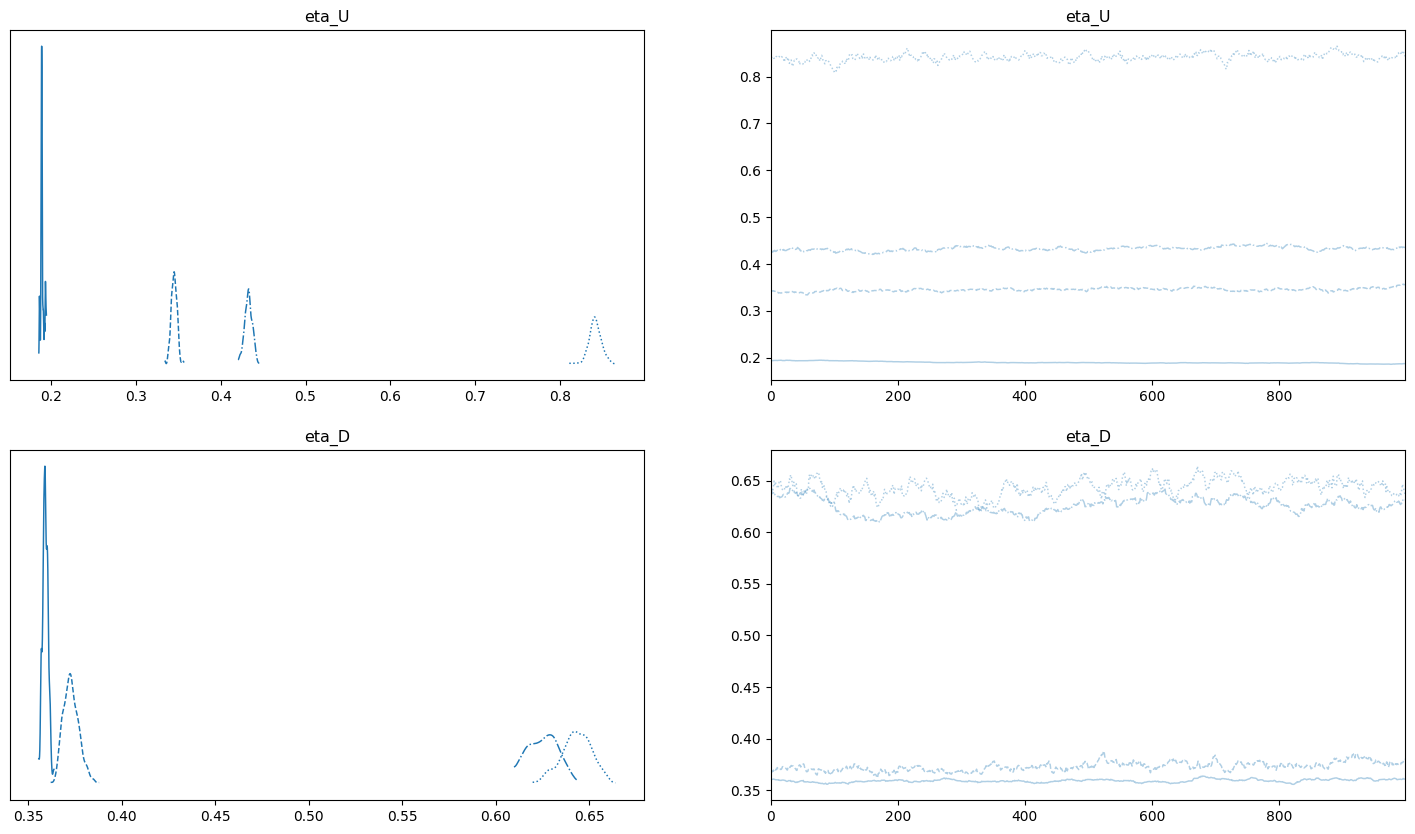

In [ ]:
az.plot_trace(trace, var_names=['eta_U', 'eta_D'], figsize=(18, 10));


In [ ]:
# az.plot_trace(trace, var_names=["step_size", "nu"]);

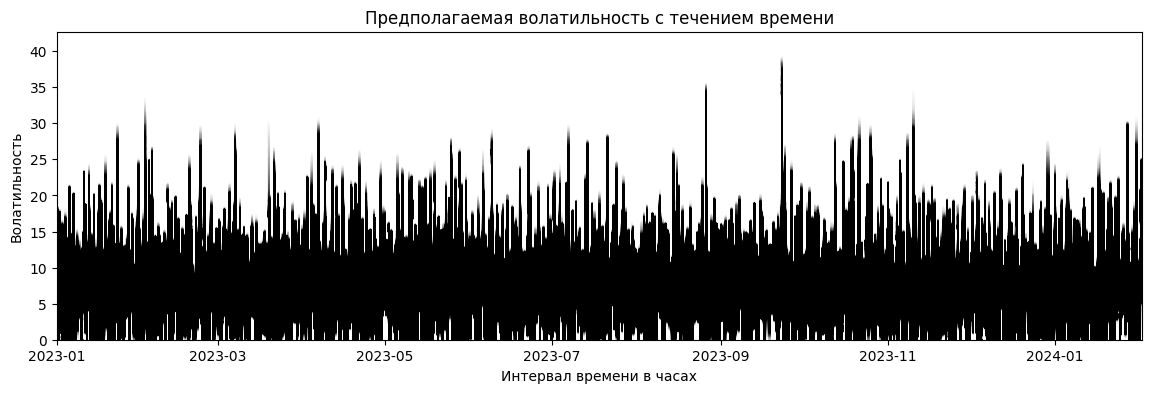

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = posterior_predictive['y_exp']

x_vals = y_vals['Datetime']

plt.plot(x_vals, y_vals, 'k', alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title='Предполагаемая волатильность с течением времени', xlabel='Интервал времени в часах', ylabel='Волатильность');

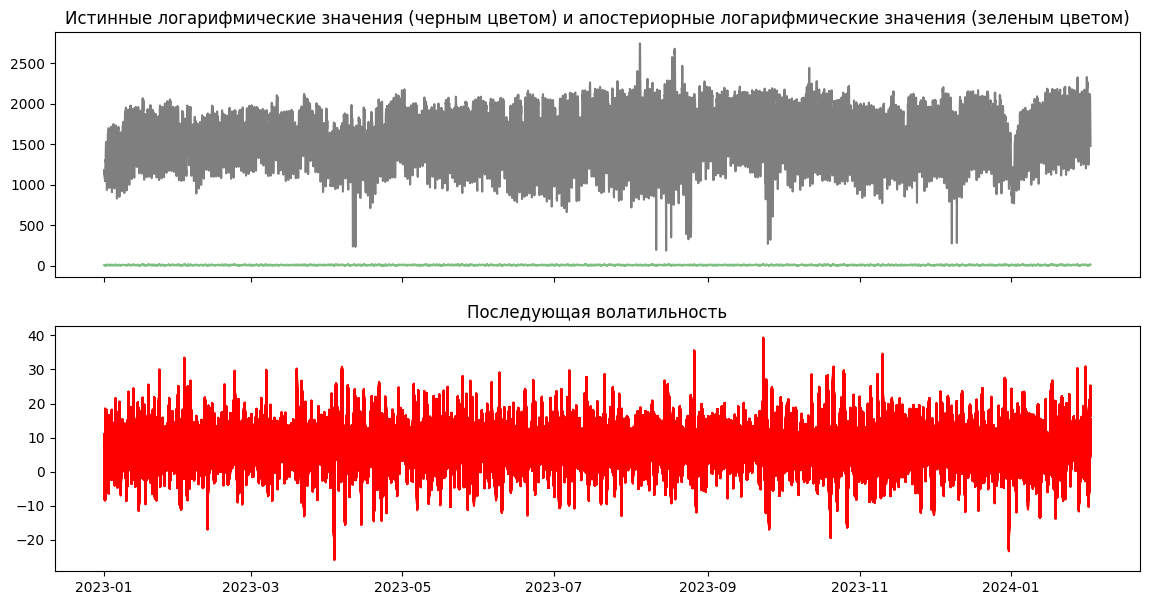

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
axes[0].plot(df['Datetime'], df['Price, RUB/MWh.'], color='black', alpha=0.5)

# pred_y_vals = posterior_predictive['y_obs']
pred_y_vals = trace.posterior_predictive['y_obs'].mean(('chain', 'draw'))
pred_x_vals = pred_y_vals['Datetime']
axes[0].plot(pred_x_vals, pred_y_vals, 'g', alpha=0.5, zorder=-10)
axes[1].plot(x_vals, y_vals, 'r', alpha=0.5)

axes[0].set_title('Истинные логарифмические значения (черным цветом) и апостериорные логарифмические значения (зеленым цветом)')
axes[1].set_title('Последующая волатильность');

In [14]:
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

y_obs = trace.posterior_predictive['y_obs'].mean(('chain', 'draw'))
y = df['log_Price, RUB/MWh.']

print(f'RMSE: {mean_squared_error(y, y_obs, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(y, y_obs)}')
print(f'MAE: {mean_squared_error(y, y_obs)}')
print(f'R^2: {r2_score(y, y_obs)}')

RMSE: 0.21871491268855456
MAPE: 0.02689203536505716
MAE: 0.047836213032362046
R^2: 0.18682787475528106
